In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from autots import AutoTS

In [2]:
well_data = pd.read_excel('../data/Data-Wells.xlsx')
rm_nd = well_data.loc[well_data['1,4-Dioxane Results (ppb)'] != 'nd'].copy()
rm_capital_nd = rm_nd.loc[rm_nd['1,4-Dioxane Results (ppb)'] != 'ND'].copy()
rm_capital_nd['1,4-Dioxane Results (ppb)'] = rm_capital_nd['1,4-Dioxane Results (ppb)'].map(lambda x: x.replace(',', ''))
rm_capital_nd['1,4-Dioxane Results (ppb)'] = rm_capital_nd['1,4-Dioxane Results (ppb)'].map(lambda x: x.replace('<', ''))
res = rm_capital_nd
res.loc[:, 'ds']= pd.to_datetime(res['Date Sampled'])
res.loc[:, 'dioxane_results']= pd.to_numeric(res['1,4-Dioxane Results (ppb)'])
di_time = res.iloc[:, lambda df: df.columns.str.contains('Well Name|ds|dioxane_results',
                                              case=False)].copy()
di_time.rename(columns = {'dioxane_results':'y'}, inplace = True)
di_time.head(20)

,Well Name,ds,y
16,110 Parkland Plaza,1986-08-22,17.0
17,110 Parkland Plaza,1986-09-19,17.0
18,110 Parkland Plaza,1986-10-10,12.0
19,110 Parkland Plaza,1986-10-10,1.0
20,110 Parkland Plaza,1987-11-09,7.0
21,110 Parkland Plaza,1987-11-09,18.0
22,110 Parkland Plaza,1988-04-18,13.0
23,110 Parkland Plaza,1988-12-09,14.0
24,110 Parkland Plaza,1989-07-19,11.0
25,110 Parkland Plaza,1990-01-30,12.0


In [22]:

import json
def is_json(myjson):
  try:
    json_object = json.loads(myjson)
  except ValueError as e:
    return False
  return True

def format_model(model_str):
    strs = model_str.split('\n')
    print('strs = ',strs)
    res_str = ''
    for s in strs:
        s = s.replace("\"{", "{")
        s = s.replace("}\"", "}")
        s = s.replace("\\", "")
        if is_json(s):
            res_str += json.dumps(json.loads(s), indent=2) + '\n'
        else:
            res_str += s + '\n'
    return res_str

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


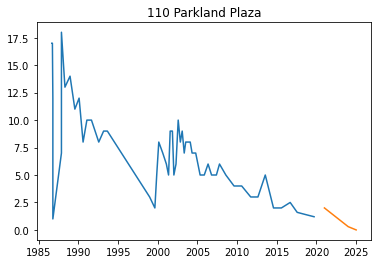

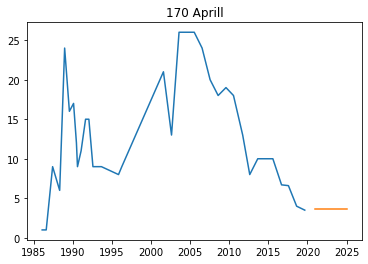

In [23]:
IS_DEBUG = False
grouped = di_time.groupby('Well Name')
n_rows = 1
count = 0
all_well_data = []
for name, group in grouped:
    if count >= 2:
        break
    try:
        group['Date'] = pd.to_datetime(group['ds'])
        group.set_index('Date', inplace=True)
        mod = AutoTS(forecast_length=5, frequency='Y',  ensemble='simple', no_negatives=True,
                    min_allowed_train_percent = 0.2,
                    verbose=-4)
        mod = mod.fit(group, date_col='ds', value_col='y', id_col=None)
        # print(mod)
        prediction = mod.predict()
        forecast = prediction.forecast
        # model_results = mod.results()
        # validation = mod.results("validation")
        #Forecast
        # print(forecast)

        ft = open("../result/mod/" + name + '.txt', "w")
        ft.write(format_model(str(mod)))
        ft.close()

        fig, ax = plt.subplots()
        ax.plot(group.y,  label='a')
        ax.plot(forecast,  label='b')
        ax.set_title(name)
        plt.savefig('../result/fig/'+name+'.png')

        all_well_data.append((name, group.y, forecast, mod))
        count+=1

        #Validation Results
        # print(validation)
    except KeyboardInterrupt:
        break
    except:
        print("[predict error]", name)
        count+=1
        continue

In [26]:
from pathlib import Path
f = open("../result/summary.md", "w")
# Path("../result/fig/").mkdir(parents=True, exist_ok=True)
f.write("# Summary\n")
for i in all_well_data:
    f.write("## "+i[0]+"\n")
    ##plot
    # fig, ax = plt.subplots()
    # ax.plot(i[1],  label='a')
    # ax.plot(i[2],  label='b')
    # plt.savefig('../result/fig/'+i[0]+'.png')

    model_str =Path("../result/mod/" + i[0] + '.txt').read_text()
    f.write('`\n'+ model_str +'`\n')
    # print(format_model(str(i[3])))
    f.write('\n')
    f.write('![](./fig/'+str(i[0]).replace(' ', '_')+'.png)\n')
f.close()

In [6]:
f = open("../result/summary.md", "w")
f.close()